# Generate Human Experiment Figure for KDG paper submission
It is the same experiment from 5/18/2021, but modified for KDG paper for 2022 ICML submission. Here we `removed SVM`, and made minor styling changes.

Update -- we further changed the style since last update

In [1]:
# changing cwd
%cd ..

/home/jmshin/Desktop/workstation/extrapolation


## Load packages

In [2]:
from src.inductive_bias import IB
ib = IB() #instantiate inductive bias package

[ /home/jmshin/Desktop/workstation/extrapolation/clf/SimulationData.pickle ] loaded
[ /home/jmshin/Desktop/workstation/extrapolation/clf/PosteriorData.pickle ] loaded
[ /home/jmshin/Desktop/workstation/extrapolation/clf/TrainedCLF.pickle ] loaded
[ /home/jmshin/Desktop/workstation/extrapolation/clf/EstimatedData.pickle ] loaded
[ /home/jmshin/Desktop/workstation/extrapolation/clf/HellingerData.pickle ] loaded
Size of the S-XOR: (6322,)                    
Size of the Spiral: (6276,)                    
Size of the whole dataset: (12598, 7)

Size of the S-XOR after adding hellinger: (6322, 8)            
Size of the Spiral after adding hellinger: (6276, 8)


In [3]:
ib.load_sampledData()

[ /home/jmshin/Desktop/workstation/extrapolation/clf/SampledData.pickle ] loaded


## Time and Date of the experiment

In [4]:
print(ib.date)

2022-02-04 00:12:30.848400


## Load dependencies

In [5]:
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle

cmap = 'RdBu_r'

import warnings
warnings.filterwarnings('ignore')

#image output
import os
import imageio

## Extract human coordinates

In [6]:
ib.extract_human_coord()

User sequence match and dataframe exported


In [7]:
ib.humanLoc[0][0].head()

,3,5
336,-2.59,0.74
337,0.56,1.55
338,-2.05,-0.7
339,2.27,-1.78
340,1.46,-0.61


## Retraining ML models and predicting exactly the same xy coordinates from human experiment

In [8]:
ib.mask = ib.generate_mask(h=0.1)
ib.mask.shape

(3600, 2)

In [9]:
#generic global
uX = ib.mask
uX0, uX1 = uX[:,0], uX[:,1]
label = ['DN'] + ib.mtype[2:3] + ['Human']
dtype = ib.dtype[2:5:2]
fsize = 25

#retrain global
reps = 126
saved_clf = ib.clf #using already optimized hyper-parameter from previous models
N_sample = 100 #same number of samples that of human
h = 0.1
rng = 3

#train
TRAIN_NOW = False

#figure
SAVEFIG = True

In [10]:
# run only for the first time
if TRAIN_NOW:
    ib.get_sampledData(saved_clf=saved_clf, reps=reps, N_sample=N_sample, h=0.1, rng=3)

## The grid matching yields equal number of points between human and machine

In [11]:
# ML grid vs human grid
ib.estpst_sample[0][0].shape, ib.human[0].shape, ib.estpst_sample[1][0].shape, ib.human[1].shape

((6276, 3), (6276, 8), (6322, 3), (6322, 8))

## The grid size matches after point-wise averaging

In [12]:
ib.pointwise_gridAverage(ib.estpst_sample[0][0]).shape, ib.pointwise_gridAverage(np.column_stack([ib.human[0][:,3], ib.human[0][:,5], ib.human[0][:,0]])).shape

((3497, 3), (3497, 3))

In [13]:
ib.pointwise_gridAverage(ib.estpst_sample[1][0]).shape, ib.pointwise_gridAverage(np.column_stack([ib.human[1][:,3], ib.human[1][:,5], ib.human[1][:,0]])).shape

((3098, 3), (3098, 3))

## Point-wise averaging and gaussian smoothing estimated posterior

In [14]:
mtype = []
ib.mask = ib.generate_mask(h=0.1)

for ii in range(2): #S-XOR and spiral
    mtype.append([])
    
    for jj in range(1,4):
        if jj == 3:
            mtype_i = np.column_stack([ib.human[ii][:,3], ib.human[ii][:,5], ib.human[ii][:,0]]) # human estimates
        else:
            mtype_i = ib.estpst_sample[ii][jj] # ML estimates        
        
        mtype_i = ib.pointwise_gridAverage(mtype_i).to_numpy()        
        xy, original, down, alls = ib.smooth_gaussian_distance(mtype_i, step=0.01, method=None, sigma=1, k=10)
        mtype[ii].append(alls)

## Generate compiled plot and output images

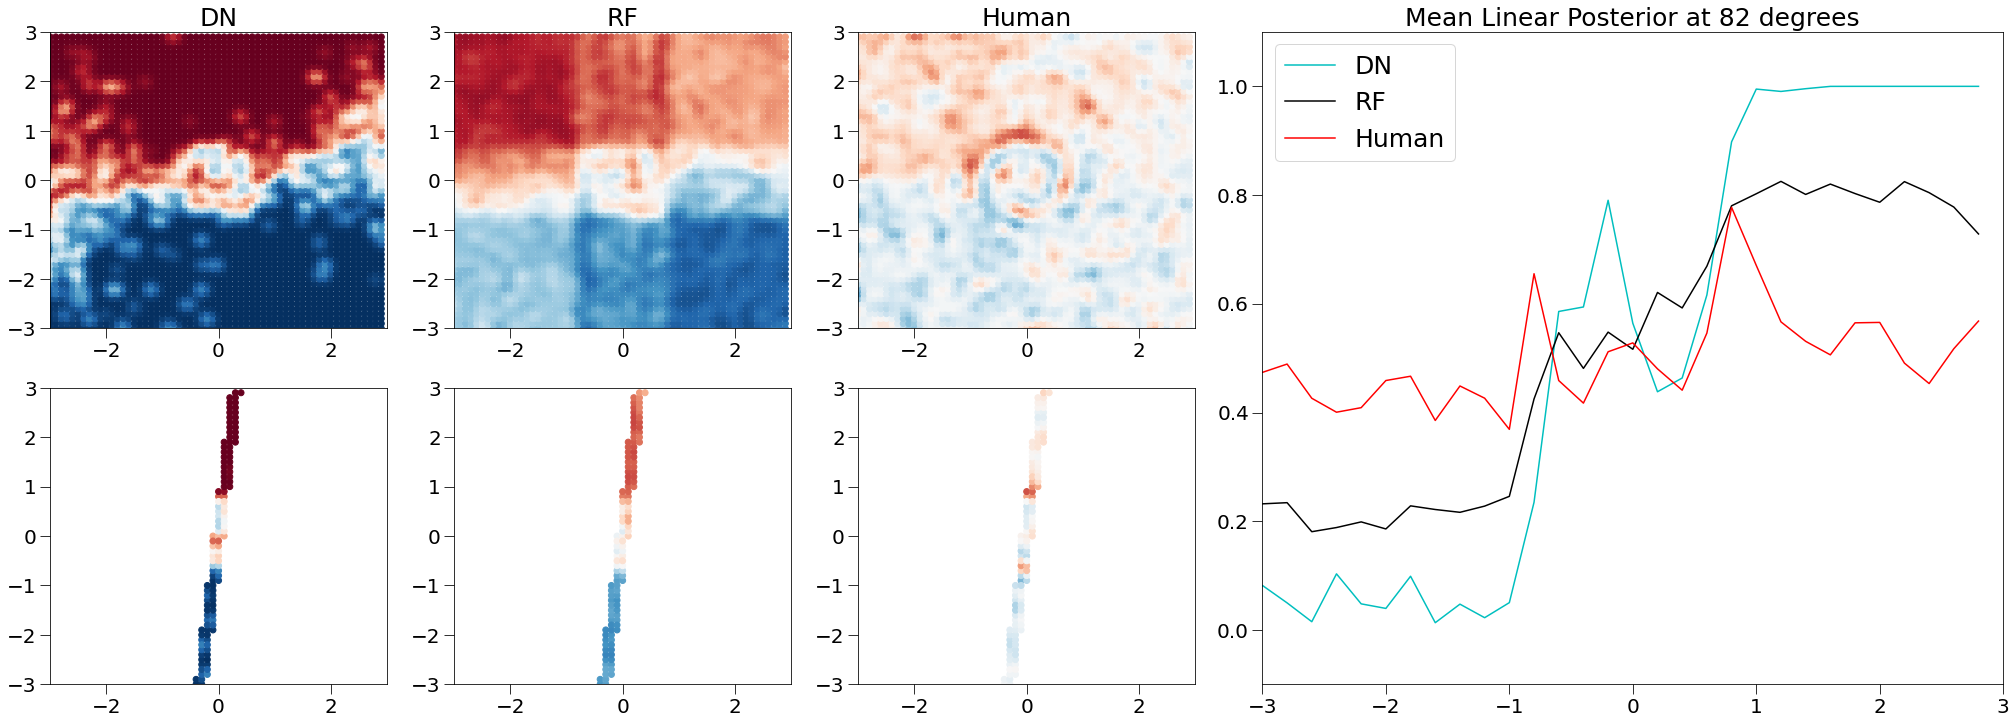

In [15]:
angle_step = 12
new_dtype = ['Original'] + dtype
fdtype = ['spiral'] #dtype defined for filename

palette = sns.color_palette('bright', len(ib.mtype))
palette = sns.color_palette(['c','k','r'], as_cmap=True)

col = 5 #CHANGED
row = 2

step = 0.2
r = 4
x_range = np.arange(-r,r,step)

for sw, lb in enumerate(fdtype):
    # for deg in np.arange(0, 180+angle_step, angle_step):
    for deg in [84]:

        line_plot = []
        line_post = []

        fig, axs = plt.subplots(row,col,figsize=(5*(col+2),6*row))
        gs = axs[0, 3].get_gridspec() #CHANGED HERE

        # remove the underlying axes
        for ax in axs[:, -1]:
            ax.remove()

        for ax in axs[:, -2]:
            ax.remove()

        for i in range(2):    
            line_plot.append([])
            line_post.append([])

            for j in range(3):
                # if i == 0: #exclude SVM
                #     continue

                line_plot[i].append([])
                line_post[i].append(ib.select_linear_region(mtype[i][j], degree=deg, step=0.001))
                
                lp, li = line_post[i][j] #line posterior, line index
                x = ib.mask[li][:,0]
                y = ib.mask[li][:,1]
                dist = np.sqrt(x**2 + y**2)

                dist[y < 0] *= -1 # negative radial distance wrt y-coordinate

                for rad in x_range:
                    line_plot[i][j].append(np.array(lp[(dist >= rad) * (dist < rad+step)]).mean())

        for m in range(2):
            for i in range(3):
                # if i == 0: #exclude SVM
                #     continue
                
                if m == 0:
                    axs[m,i].scatter(ib.mask[:,0], ib.mask[:,1], c=mtype[sw][i], cmap=cmap, vmin=0, vmax=1) #switch here
                    
                else:
                    ibXY = ib.mask[line_post[m-1][i][1]]
                    axs[m,i].scatter(ibXY[:,0], ibXY[:,1], c=line_post[sw][i][0], cmap=cmap, vmin=0, vmax=1)

                # figure styling
                if m == 0:
                    axs[m,i].set_title(label[i], fontsize=fsize)

                # if i == 0:
                #     axs[m,i].set_ylabel(new_dtype[m], fontsize=fsize)

                axs[m,i].set_xlim(-3,3)
                axs[m,i].set_ylim(-3,3)
                # axs[m,i].set_xticklabels(fontsize=18)
                # axs[m,i].set_yticklabels(fontsize=18)
                axs[m,i].tick_params(axis='both', labelsize=20, length=10)
                # axs[m,i].tick_params(axis='y', labelsize=20)
                
                
        axbig = fig.add_subplot(gs[:, -2:])

        tempdf = pd.DataFrame(np.array(line_plot[sw]).T, columns=label) #switch here
        tempdf.index = x_range
        for i, lab in enumerate(label):
            sns.lineplot(data=tempdf[[lab]], ax=axbig, palette=[palette[i]]) #palette[[0,2,3][i]]

        axbig.legend(loc=0, fontsize=25)
        axbig.set_title(['Mean Linear Posterior at 82 degrees', 'S-XOR'][sw], fontsize=fsize)
        axbig.set_ylim([-0.1,1.1])
        axbig.set_xlim(-3,3)
        axbig.tick_params(axis='both', labelsize=20, length=10)

        if SAVEFIG:  
            plt.savefig(f'figs/[20220203_generate_figure_for_kdg_paper]_human_experiment_spiral.pdf', bbox_inches='tight')

        plt.show()
